In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<h2>Data Exploration and Cleaning

In [11]:
#Loading data
data_path = "./" 
train = pd.read_csv(data_path + "train.csv")
test = pd.read_csv(data_path + "test.csv")

In [12]:
# Data exploration
print("Train Data Info:\n", train.info())
print("Test Data Info:\n", test.info())
print("Train Sample:\n", train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
Train Data Info:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
Test Data Info:
 None
Train Sample:
    id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of t

In [13]:
#Checking for missing values
print("Missing Values in Train Data:\n", train.isnull().sum())
print("Missing Values in Test Data:\n", test.isnull().sum())

Missing Values in Train Data:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Missing Values in Test Data:
 id             0
keyword       26
location    1105
text           0
dtype: int64


In [14]:
#Handling missing values
train['keyword'] = train['keyword'].fillna('')
train['location'] = train['location'].fillna('')
test['keyword'] = test['keyword'].fillna('')
test['location'] = test['location'].fillna('')

In [15]:
#Rechecking if any missing values exist
print("Missing Values after Imputation:\n", train.isnull().sum())

Missing Values after Imputation:
 id          0
keyword     0
location    0
text        0
target      0
dtype: int64


**Exploratory Data Analysis (EDA)**

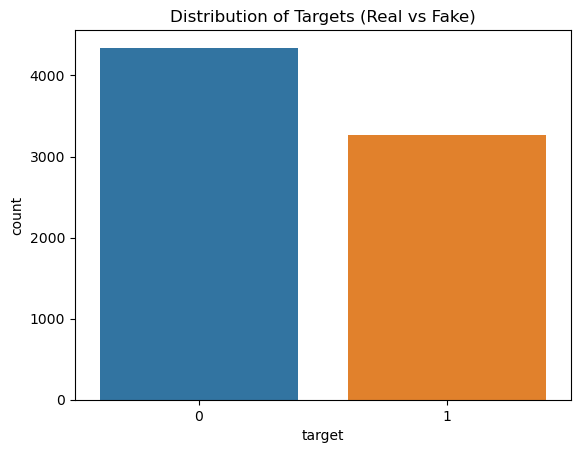

In [16]:
#Distribution of target
sns.countplot(x='target', data=train)
plt.title("Distribution of Targets (Real vs Fake)")
plt.show()

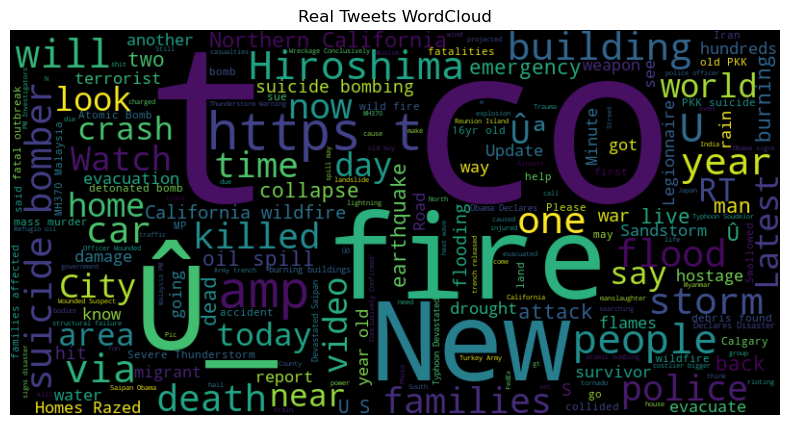

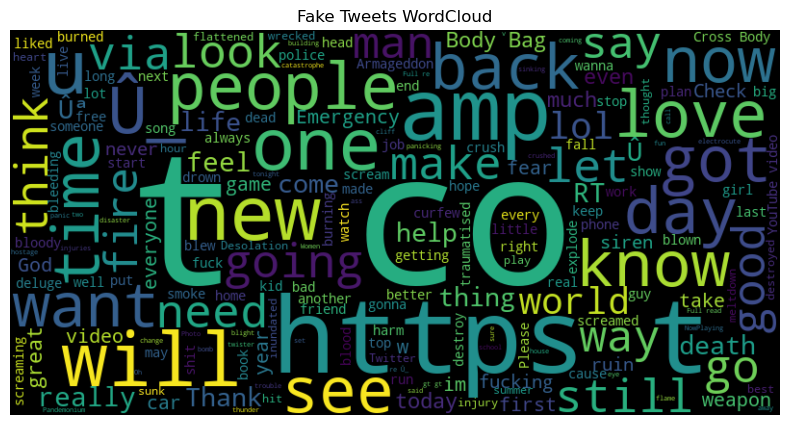

In [18]:
from wordcloud import STOPWORDS

#generating word clouds with the stopwords
real_tweets = " ".join(train[train['target'] == 1]['text'])
fake_tweets = " ".join(train[train['target'] == 0]['text'])
wordcloud_real = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(real_tweets)
wordcloud_fake = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(fake_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Real Tweets WordCloud")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Fake Tweets WordCloud")
plt.axis("off")
plt.show()


<h2>Text Preprocessing

In [19]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

train['clean_text'] = train['text'].apply(preprocess_text)
test['clean_text'] = test['text'].apply(preprocess_text)

In [20]:
#some cleaned text
print(train['clean_text'].head())

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: clean_text, dtype: object


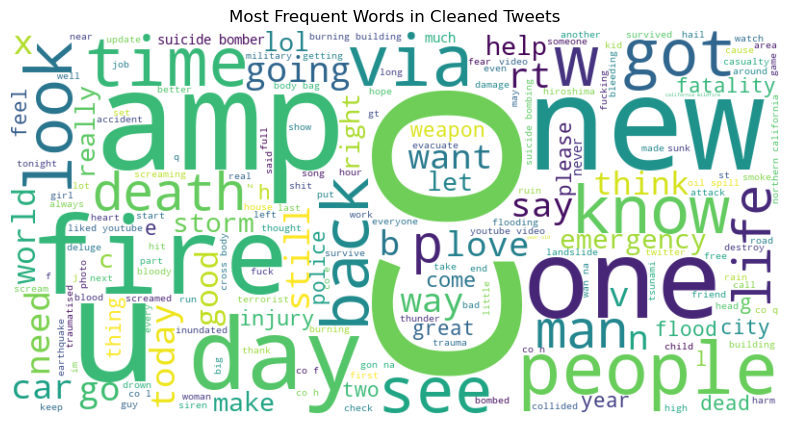

In [21]:
#Combining all clean text for visualization
all_clean_text = " ".join(train['clean_text'])

wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color='white').generate(all_clean_text)

#Plot of word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Frequent Words in Cleaned Tweets")
plt.axis("off")
plt.show()

<h2>Feature Extraction

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

#Bag of Words with CountVectorizer
vectorizer_bow = CountVectorizer(max_features=5000)
X_bow = vectorizer_bow.fit_transform(train['clean_text'])
X_test_bow = vectorizer_bow.transform(test['clean_text'])

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

#TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train['clean_text'])
X_test = vectorizer.transform(test['clean_text'])
y = train['target']

In [24]:
#shape of the features
print(X_bow.shape, X.shape)

(7613, 5000) (7613, 5000)


<h2>Model Building

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Splitting the data into training and validation sets
X = X
y = train['target']  
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

#Support Vector Machine(SVM)
svm_model = SVC()
svm_model.fit(X_train, y_train)

#Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

#Predictions and evaluation
models = [lr_model, svm_model, nb_model]
for model in models:
    y_pred = model.predict(X_val)
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("\n")

Model: LogisticRegression
Accuracy: 0.7977675640183848
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.83       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

Confusion Matrix:
 [[776  98]
 [210 439]]


Model: SVC
Accuracy: 0.7971109652002626
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84       874
           1       0.83      0.66      0.73       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

Confusion Matrix:
 [[786  88]
 [221 428]]


Model: MultinomialNB
Accuracy: 0.7997373604727511
Classification Report:
               precision    recall  f1-sco

<h2>Hyperparameter Tuning

In [26]:
#Example for Logistic Regression tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200, 300]
}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

#Best parameters and performance
print("Best Parameters:", grid_search_lr.best_params_)
print("Best Score:", grid_search_lr.best_score_)

Best Parameters: {'C': 1, 'max_iter': 100}
Best Score: 0.7947454844006567


<h2> Visualization and Analysis

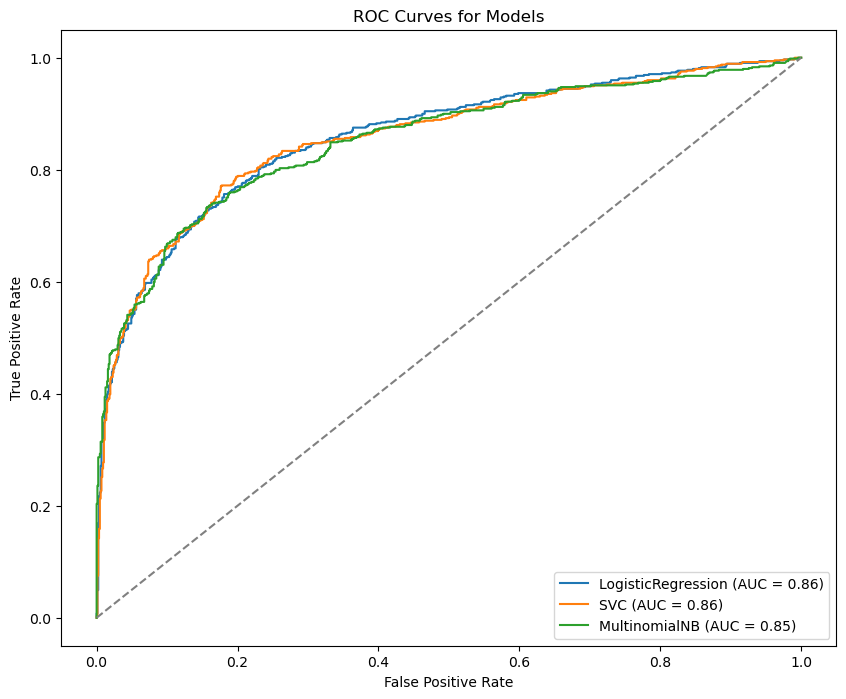

In [27]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

#ROC Curves for each model
plt.figure(figsize=(10, 8))

#Looping through each model to plot ROC curves
for model in models:
    #ensuring probability=True is set for SVM and refit i
    if isinstance(model, SVC) and not hasattr(model, 'predict_proba'):
        model = SVC(probability=True)
        model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_val)[:, 1]  #Probability estimates for the positive class
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    #Plot 
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')

#diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

#labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc='lower right')
plt.show()

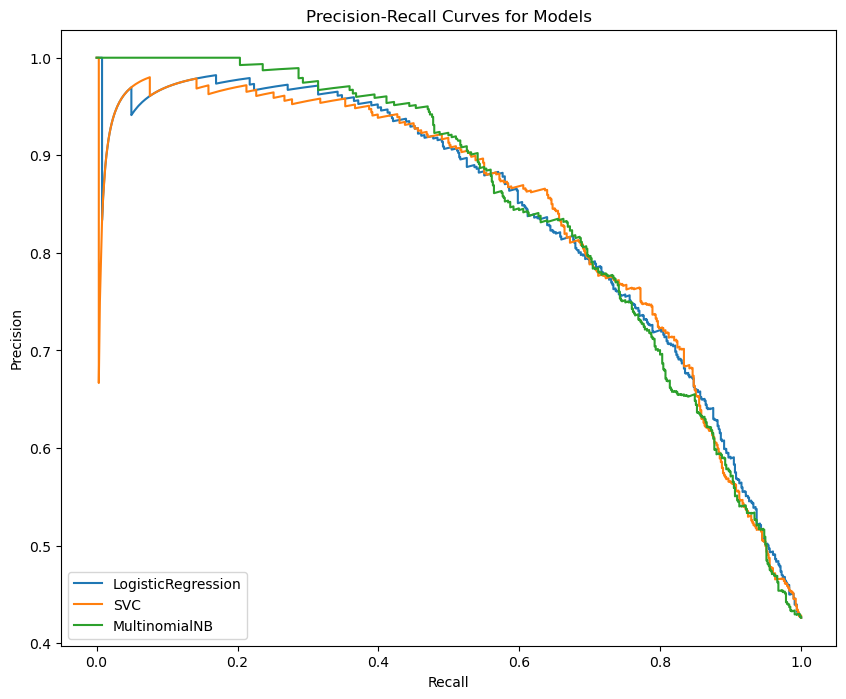

In [110]:
#SVM with probability=True
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

#Precision-Recall Curves for each model
plt.figure(figsize=(10, 8))

#Looping through each model to plot Precision-Recall curves
for model in models:
    #ensuring probability=True is set for SVM and refit i
    if isinstance(model, SVC) and not hasattr(model, 'predict_proba'):
        model = SVC(probability=True)
        model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]  #Probability estimates for the positive class
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    
    #Plot
    plt.plot(recall, precision, label=f'{model.__class__.__name__}')

#labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Models')
plt.legend(loc='lower left')
plt.show()

In [28]:
#Looping through each model to get misclassified examples
for model in models:
    y_pred = model.predict(X_val)
    
    #Identifying misclassified samples
    misclassified_indices = y_pred != y_val
    
    #actual text for misclassified examples 
    misclassified_text = vectorizer.inverse_transform(X_val[misclassified_indices])  # Converting sparse to text
    misclassified_labels = y_val[misclassified_indices]
    misclassified_predictions = y_pred[misclassified_indices]
    
    #Flatten the list of words for each misclassified sample
    misclassified_text = [" ".join(text) for text in misclassified_text]
    
    #Creating a DataFrame to display misclassified examples
    misclassified_df = pd.DataFrame({
        'Misclassified Text': misclassified_text,
        'True Label': misclassified_labels,
        'Predicted Label': misclassified_predictions
    })
    
    print(f"Misclassified examples for {model.__class__.__name__}:")
    print(misclassified_df.head())  #first 5 misclassified examples
    print("\n")


Misclassified examples for LogisticRegression:
                                     Misclassified Text  True Label  \
2644                    cause destruction new un weapon           1   
1765  came co collision favorite hopefully http ij j...           1   
1817  crashed fail gas like people person po pump qu...           1   
4019  america bringing change climate farrakhan floo...           0   
2534  co desolation escape glad heat http loop run t...           0   

      Predicted Label  
2644                0  
1765                0  
1817                0  
4019                1  
2534                1  


Misclassified examples for SVC:
                                     Misclassified Text  True Label  \
2644                    cause destruction new un weapon           1   
1765  came co collision favorite hopefully http ij j...           1   
1817  crashed fail gas like people person po pump qu...           1   
1807       avoid car co cop http man news pull vn world         